In [892]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.layers import LSTM, Input, Dense, Conv1D, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
import time
import pytrends
from pytrends.request import TrendReq
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, RocCurveDisplay


In [848]:
df = pd.read_csv("MOEX_070105_221221.csv")
df = df.drop(["<TIME>", "<TICKER>", "<PER>", "<OPEN>", "<HIGH>", "<LOW>", "<VOL>"], axis=1)
df["<DATE>"] = pd.to_datetime(df["<DATE>"], format="%Y%m%d")
df

,<DATE>,<CLOSE>
0,2013-02-11,55.00
1,2013-02-18,54.50
2,2013-02-25,52.50
3,2013-03-04,53.99
4,2013-03-11,55.00
...,...,...
507,2022-11-21,87.60
508,2022-11-28,87.02
509,2022-12-05,88.17
510,2022-12-12,84.95


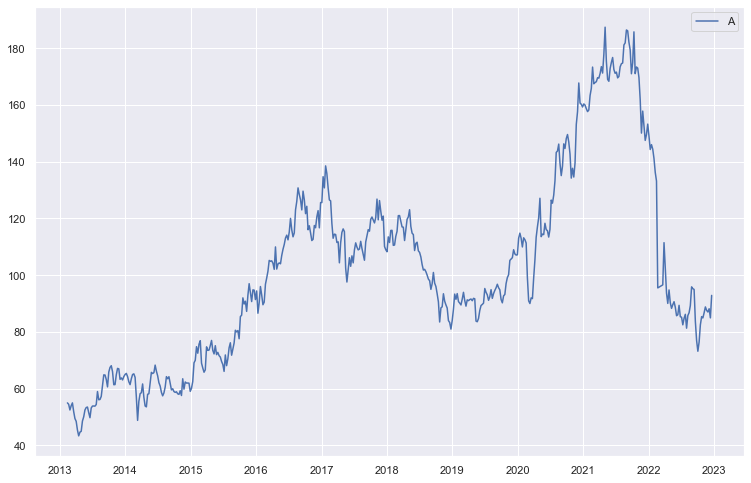

In [849]:
plt.plot(df["<DATE>"], df["<CLOSE>"])
plt.legend("Акции МосБиржи с 2013г.")

Load data from Google trends

In [850]:
pytrend = TrendReq()

def make_gtrend_table(word, year = 2013):
    ress = pd.DataFrame()
    for y in range(year, 2023):
        str_yr = str(y)
        pytrend.build_payload([word], timeframe=f"{y}-01-01 {y+1}-01-01")
        result = pytrend.interest_over_time()
        ress = pd.concat([ress, result])
    return ress

lst_of_words = ["мосбиржа", "долг", "инвестор", "экономика", "акции", "инвестиции", "портфель", "инфляция", \
    "кризис", "кредит", "доход", "капитал", "вложить", "война", "заболеваемость", "правительство", \
    "закон", "парламент", "сбербанк", "газпром", "роснефть", "нефть", "короновирус", "covid",  \
    "санкции", "США", "газ", "вклад", "депозит", "облигация", "оружие", "спрос", "новости", "украина",\
    "германия", "тинькофф", "центробанк", "какие акции купить в 2022",  "акции сбербанка курс", \
    "индекс мосбиржи", "vk акции", "акции входящие в состав мосбиржи", "газета ру", "риа новости", \
    "рбк инвестиции", "нефть брент", "курс доллара", "курс евро", "яндекс"]

def get_pytrend_data(lst_of_words, cols):
    count = 0
    for term in lst_of_words:
        print(f"{term} get")
        c = 0
        while (c < 5):
            try:
                res = make_gtrend_table(term)
                cols[term] = res
                break
            except:
                time.sleep(5)
                c+=1


cols = {}
get_pytrend_data(lst_of_words, cols)
total_trend_data = pd.concat(cols.values(), axis=1)
total_trend_data = total_trend_data.drop(["isPartial"], axis=1)
total_trend_data["date"] = total_trend_data.index
total_trend_data["date"] = total_trend_data.apply(lambda x: x["date"] + pd.DateOffset(days=1), axis=1)
total_trend_data = total_trend_data.set_index("date")
total_trend_data.to_csv("total_trend_data.csv")
display(total_trend_data)

ConnectionError: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /?geo=US (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001CE936C0CD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
res = []
for i in df.index:
    try:
        int(total_trend_data.iloc[i, 2])
        res.append([df.loc[i, "<DATE>"], df.loc[i, "<CLOSE>"], *total_trend_data.iloc[i,:]])
    except Exception as e:
        print(f"{e}")
        continue
res = pd.DataFrame(res, columns = ["date", "price", *total_trend_data.columns])
res = res.set_index("date")

In [ ]:
res

,price,мосбиржа,долг,инвестор,экономика,акции,инвестиции,портфель,инфляция,кризис,...,какие акции купить в 2022,акции сбербанка курс,индекс мосбиржи,vk акции,газета ру,риа новости,рбк инвестиции,нефть брент,курс доллара,курс евро
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,55.00,0,61,61,56,37,63,41,68,60,...,0,0,0,0,85,24,69,0,56,55
2013-02-18,54.50,0,72,62,74,38,76,65,73,71,...,0,41,0,0,74,33,43,0,59,52
2013-02-25,52.50,100,67,86,73,40,81,62,78,65,...,0,0,0,0,74,35,0,0,59,49
2013-03-04,53.99,0,74,59,62,41,77,64,67,60,...,34,0,32,0,68,34,0,0,60,52
2013-03-11,55.00,0,71,56,65,40,79,57,67,57,...,0,0,0,0,71,36,100,89,59,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21,87.60,23,56,55,58,36,50,73,26,41,...,9,2,48,29,42,44,13,25,17,24
2022-11-28,87.02,25,53,44,58,33,47,75,27,56,...,0,3,39,16,43,48,38,38,18,30
2022-12-05,88.17,11,57,42,54,37,40,74,25,54,...,0,0,11,18,38,40,25,24,15,25


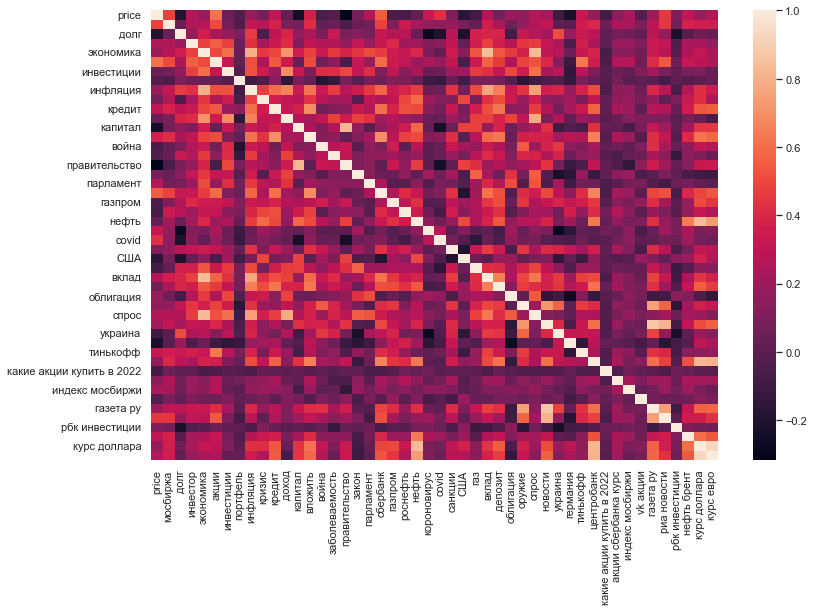

BEST SEARCHES (r>0.3)


,idx,parameter,correlation
0,0,price,1.000
1,1,мосбиржа,0.471
2,5,акции,0.605
3,10,кредит,0.302
4,13,вложить,0.366
5,19,сбербанк,0.551
6,23,короновирус,0.329
7,24,covid,0.428
8,36,тинькофф,0.329
9,43,риа новости,0.454


In [ ]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
sns.heatmap(res.corr())
plt.show()
print("BEST SEARCHES (r>0.3)")
corrl = []
kws = res.corr()["price"].keys()
corrdf = res.corr()["price"]
for i in range(len(kws)):
    if (corrdf[kws[i]] > 0.3 or corrdf[kws[i]] < -0.3):
        corrl.append((i, kws[i], round(corrdf[kws[i]], 3) ))
best_corr = pd.DataFrame(corrl, columns = ["idx","parameter", "correlation"])
display(best_corr)

In [ ]:
from scipy.stats import pearsonr
best_corr["p-value"] = 0
for cidx in range(1, 11):
    c = best_corr.loc[cidx, "parameter"]
    column_corr = pearsonr(res[c], res["price"])
    best_corr.loc[cidx, "p-value"] = round(column_corr.pvalue, 2)
best_corr

,idx,parameter,correlation,p-value
0,0,price,1.000,0
1,1,мосбиржа,0.471,0
2,5,акции,0.605,0
3,10,кредит,0.302,0
4,13,вложить,0.366,0
5,19,сбербанк,0.551,0
6,23,короновирус,0.329,0
7,24,covid,0.428,0
8,36,тинькофф,0.329,0
9,43,риа новости,0.454,0


### Training


In [876]:
table_lag = res.copy()
table_lag["up"] = 0
for i in range(1, len(table_lag)):
    if (table_lag.iloc[i, 0] >= table_lag.iloc[i-1, 0] ):
        table_lag.iloc[i, -1] = 1
scaler = StandardScaler()
scaler = scaler.fit(table_lag.iloc[:, :-1])
pricedata_scaled = scaler.transform(table_lag.iloc[:, :-1])
pricedata_scaled = np.hstack([pricedata_scaled, table_lag.iloc[:, -1:]])

In [ ]:
def prepare_data(winsize = 2, params_set="all", flatten=True):
    X = []
    y = []
    for i in range(pricedata_scaled.shape[0]-winsize):
        X_tmp = None
        if (params_set == "all"):
            X_tmp = pricedata_scaled[i:i+winsize, :-1]
        elif (params_set == "keywords"):
            X_tmp = pricedata_scaled[i:i+winsize, 1:-1]
        else:
            X_tmp = pricedata_scaled[i:i+winsize, 0:1]
        if (flatten):
            X_tmp = X_tmp.ravel()
        X.append(X_tmp)
        y.append(pricedata_scaled[i+winsize, -1])
    X = np.array(X)
    y = np.array(y)
    tsplit_idx = int(len(X)*0.8)
    X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

    print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")
    return X_train, X_test, y_train, y_test

prepare_data(2, "price", False)


In [ ]:
def train_rfr(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier()
    prms = {
        "n_estimators": [10, 50, 100,],
        "max_depth": [1, 2, 5],
        "min_samples_split" :[2, 3, 5],
        "min_samples_leaf" : [1, 2, 5, 7]
    }
    gscv = GridSearchCV(model, param_grid=prms)
    gscv.fit(X_train, y_train)
    model = gscv.best_estimator_
    y_pred = model.predict(X_test)
    print("Model params: ", model.get_params())
    print("ROC AUC Curve\n")
    RocCurveDisplay.from_predictions(y_test, y_pred)
    print("Classification report\n")
    print(classification_report(y_test, y_pred))

train_rfr(*prepare_data())


In [ ]:
def train_mlp(X_train, X_test, y_train, y_test):
    model = Sequential()
    param_num=X_train.shape[1]
    model.add(Input((param_num)))
    model.add(Dense(64, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(32, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(metrics="accuracy", loss="binary_crossentropy")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)

    plt.plot(history.history["val_accuracy"])
    plt.plot(history.history["loss"], "r")
    plt.title("Validfation")
    plt.legend(["Validation accuracy", "Train crossentropy"])
    plt.show()

    y_pred = model.predict(X_test)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()
    y_pred_bin = [0 if i < 0.9 else 1 for i in y_pred]
    print("Classification metrics\n")
    print(classification_report(y_test, y_pred_bin))

In [ ]:
def train_lstm(X_train, X_test, y_train, y_test):
    model = Sequential()
    param_num=X_train.shape[2]
    winsize=X_train.shape[1]
    model.add(Input((winsize, param_num)))
    model.add(LSTM(64, return_sequences=False, kernel_regularizer="l2"))
    model.add(Dense(16, activation="relu", kernel_regularizer="l2"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(metrics="accuracy", loss="binary_crossentropy")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)

    plt.plot(history.history["val_accuracy"])
    plt.plot(history.history["loss"], "r")
    plt.title("Validfation")
    plt.legend(["Validation accuracy", "Train crossentropy"])
    plt.show()

    y_pred = model.predict(X_test)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()
    y_pred_bin = [0 if i < 0.9 else 1 for i in y_pred]
    print("Classification metrics\n")
    print(classification_report(y_test, y_pred_bin))

train_lstm(*prepare_data(winsize=3, params_set="price", flatten=False))

In [ ]:
for w in range(1, 5):
    for var in ["all", "keyword", "price"]:
        train_mlp(*prepare_data(winsize=w, params_set=var, flatten=True))

In [ ]:
for w in range(1, 5):
    for var in ["all", "keyword", "price"]:
        train_rfr(*prepare_data(winsize=w, params_set=var, flatten=True))

In [ ]:
for w in range(1, 5):
    for var in ["all", "keyword", "price"]:
        train_lstm(*prepare_data(winsize=w, params_set=var, flatten=False))

# Regress

Only with prices

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(res)
pricedata_scaled = scaler.transform(res)

In [868]:
def prepare_data(winsize = 2, params_set="all", flatten=True):
    X = []
    y = []
    for i in range(pricedata_scaled.shape[0]-winsize):
        X_tmp = None
        if (params_set == "all"):
            X_tmp = pricedata_scaled[i:i+winsize, :-1]
        elif (params_set == "keywords"):
            X_tmp = pricedata_scaled[i:i+winsize, 1:-1]
        else:
            X_tmp = pricedata_scaled[i:i+winsize, 0:1]
        if (flatten):
            X_tmp = X_tmp.ravel()
        X.append(X_tmp)
        y.append(pricedata_scaled[i+winsize, 0])
    X = np.array(X)
    y = np.array(y)
    tsplit_idx = int(len(X)*0.8)
    X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

    print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")
    return X_train, X_test, y_train, y_test

prepare_data(2, "price", False)

X shape (407, 3, 1) test shape (102, 3, 1) y shape (407, 1)


In [ ]:
def train_rfr(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    prms = {
        "n_estimators": [10, 50, 100,],
        "max_depth": [1, 2, 5],
        "min_samples_split" :[2, 3, 5],
        "min_samples_leaf" : [1, 2, 5, 7]
    }
    gscv = GridSearchCV(model, param_grid=prms)
    gscv.fit(X_train, y_train)
    model = gscv.best_estimator_
    y_pred = model.predict(X_test)
    print("Model params: ", model.get_params())
    print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
    print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
    print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

train_rfr(*prepare_data())

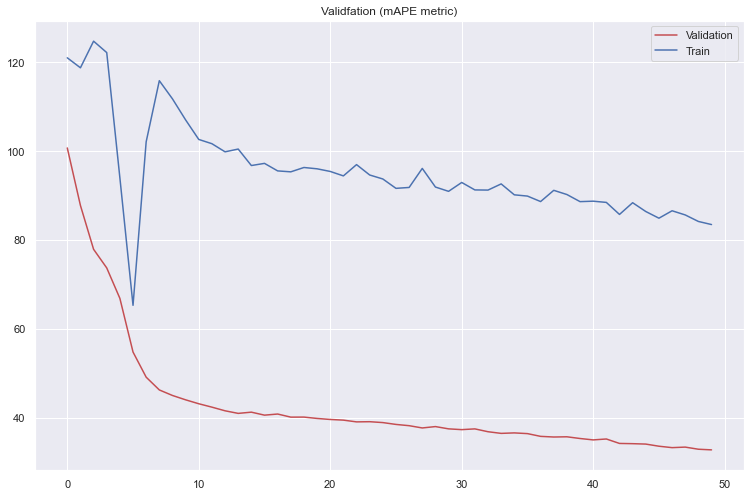

4/4 [==============================] - 0s 4ms/step
mAPE: 0.32737%
MSE (scaled): 0.059222
R2: 0.96


In [869]:
model = Sequential()
param_num=X_train.shape[2]
model.add(Input((winsize, param_num)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(metrics="mape", loss="mse", optimizer=Adam(0.001))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0)

plt.plot(history.history["val_mape"], "r-")
plt.plot(history.history["mape"])
plt.title("Validfation (mAPE metric)")
plt.legend(["Validation", "Train"])
plt.show()
y_pred = model.predict(X_test)
print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

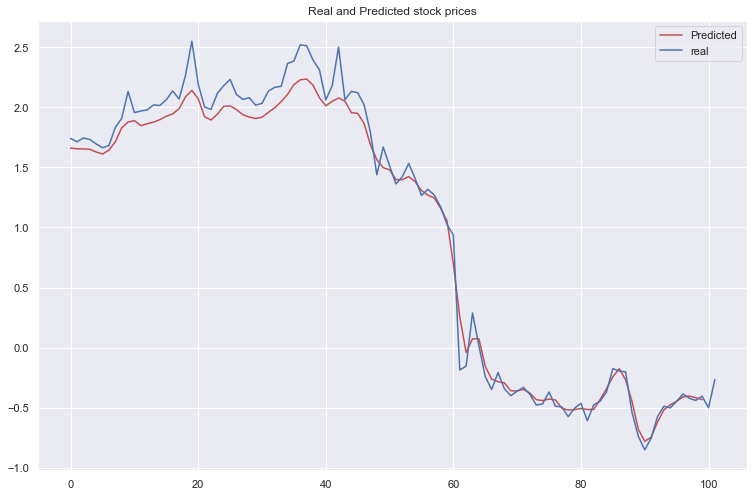

In [870]:
plt.plot(y_pred[2:], "r")
plt.plot(y_test, "b-")
plt.legend(["Predicted", "real"])
plt.title("Real and Predicted stock prices")
plt.show()

Use keywords и price as features

In [871]:
winsize = 3
X = []
y = []
for i in range(pricedata_scaled.shape[0]-winsize):
    X.append(pricedata_scaled[i:i+winsize, :-1])
    y.append(pricedata_scaled[i+winsize, 0])
X = np.array(X)
y = np.array(y)
tsplit_idx = int(len(X)*0.8)
X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")

X shape (407, 3, 47) test shape (102, 3, 47) y shape (407,)


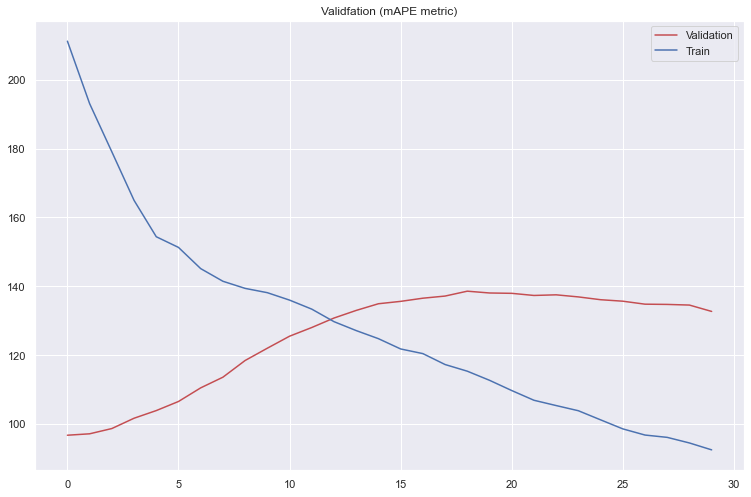

4/4 [==============================] - 0s 7ms/step
mAPE: 1.32699%
MSE (scaled): 0.965574
R2: 0.3


In [872]:
model = Sequential()
param_num=X_train.shape[2]
model.add(Input((winsize, param_num)))
model.add(LSTM(64, return_sequences=False, kernel_regularizer="l2"))
model.add(Dense(16, activation="linear"))
model.add(Dense(1, activation="linear"))
model.compile(metrics="mape", loss="mse", optimizer=Adam(0.0001))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)

plt.plot(history.history["val_mape"], "r-")
plt.plot(history.history["mape"])
plt.title("Validfation (mAPE metric)")
plt.legend(["Validation", "Train"])
plt.show()
y_pred = model.predict(X_test)
print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

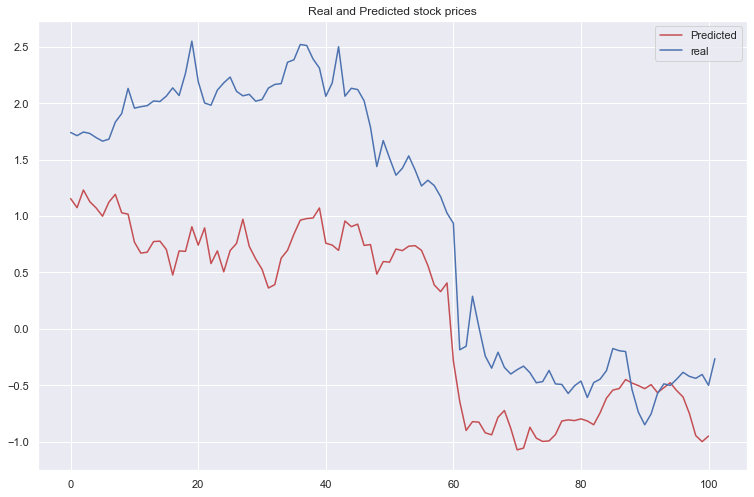

In [873]:
plt.plot(y_pred[1:], "r")
plt.plot(y_test, "b-")
plt.legend(["Predicted", "real"])
plt.title("Real and Predicted stock prices")
plt.show()